## Introduction
Nowadays, more and more data science technologies have been applied into stock investment. In order to estimate a relatively true value of the stock, many technologies such as modeling, linear regression in machine learning area, are used to assess the stock value. For example, use Capital Asset Pricing Model (CAPM) to assess the expected return of asset and risk premium model to estimate the value of stock according to bond. These formulas are derived from linear regression model. Our project is to reveal some applications of data science in stock market investment.

### Tutorial content
In this tutorial, we will show how to apply common data science tools pandas, numpy, matplotlib and special Python-based open source software framework QuantSoftware ToolKit developed by Georgia Tech into analysis of stock market.

We'll be using data collected from yahoo finance.

We will cover the following topics in this tutorial:
- [Installing and loading the libraries](#Installing-and-loading-the-libraries)
- [Metrics](#Metrics)
- [Stock Select](#Stock Select)
- [Investment Evaluation](#Investment Evaluation)
- [Place Order](#Place Order)
- [Example: Bollinger Bands](#Example: Bollinger Bands)
- [Algorithms for Model](#Example: Algorithms for Model)
- [Combining all in prediction model](#Example:Combining all in prediction model)
- [Trading strategy based on prediction](Trading strategy based on prediction)

## Installing and loading the libraries
Before getting started, you'll need to install the various libraries that we will use. You can install QuantSoftware ToolKit (QSTK) using the command below:

$ pip install QSTK

You can also follow the install instruction:http://wiki.quantsoftware.org/index.php?title=QSToolKit_Installation_Guide

After you run all the installs, make sure the following commands work for you.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import QSTK.qstkutil.qsdateutil as du
import QSTK.qstkutil.tsutil as tsu
import QSTK.qstkutil.DataAccess as da
import datetime as dt
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
# import QSTK.qstkstudy.EventProfiler as ep
import pandas as pd
import numpy as np
import math
import csv
import copy
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) # you should adjust this to fit your screen

## Metrics
First we introduce some metrics that measure how our stocks perform, how we measure the balance between return vs risk:

total_return = (value[end_of_period] / value[start_of_period]) - 1, the higher, the better

sharp_ratio = $\frac{E(Return - Return_f)} {\sqrt {Var(Return - Return_f)}}$, the higher, the better

Sortino Ratio, Jensen's Alpha and so on ......

In [136]:
def simulator(dt_start, dt_end, ls_symbols, lf_locations):
    # We need closing prices so the timestamp should be hours=16.
    dt_timeofday = dt.timedelta(hours=16)
    # Get a list of trading days between the start and the end.
    ldt_timestamps = du.getNYSEdays(dt_start, dt_end, dt_timeofday)
    # Creating an object of the dataaccess class with Yahoo as the source.
    c_dataobj = da.DataAccess('Yahoo')
    # Keys to be read from the data, it is good to read everything in one go.
    ls_keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']

    # Reading the data, now d_data is a dictionary with the keys above.
    # Timestamps and symbols are the ones that were specified before.
    ldf_data = c_dataobj.get_data(ldt_timestamps, ls_symbols, ls_keys)
    d_data = dict(zip(ls_keys, ldf_data))

    # Filling the data for NAN
    for s_key in ls_keys:
        d_data[s_key] = d_data[s_key].fillna(method='ffill')
        d_data[s_key] = d_data[s_key].fillna(method='bfill')
        d_data[s_key] = d_data[s_key].fillna(1.0)

    # Getting the numpy ndarray of close prices.
    na_price = d_data['close'].values

    # initial shares
    lf_shares = lf_locations / na_price[0, :]

    # calculate portfolio
    lf_portfolio = np.zeros(len(ldt_timestamps))
    for x in range(len(ls_symbols)):
        # print 'na_price[:, x]: ', na_price[:, x]
        # print 'lf_shares[x]', lf_shares[x]
        lf_portfolio += na_price[:, x] * lf_shares[x]
        # print 'lf_portfolio: ', lf_portfolio

    lf_portfolio_ret = np.zeros(len(ldt_timestamps))
    for y in range(len(lf_portfolio_ret)):
        if(y == 0):
            lf_portfolio_ret[y] = 0.0
        else:
            lf_portfolio_ret[y] = lf_portfolio[y] / lf_portfolio[y - 1] - 1

    vol = np.std(lf_portfolio_ret)
    daily_ret = np.average(lf_portfolio_ret)
    sharpe = daily_ret / vol * math.sqrt(252)
    cum_ret = lf_portfolio[-1]

    return vol, daily_ret, sharpe , cum_ret

In [155]:
dt_start = dt.datetime(2011, 1, 1)
dt_end = dt.datetime(2011, 12, 31)
ls_symbols = ['AAPL', 'GLD', 'GOOG', 'XOM']
lf_locations = [0.4, 0.4, 0.0, 0.2]
print 'start date: ', dt_start
print 'end date:', dt_end
print 'symbols: ', ls_symbols
print 'locations: ', lf_locations
vol, daily_ret, sharpe, cum_ret = simulator(dt_start, dt_end, ls_symbols, lf_locations)
print 'vol: ', vol
print 'daily_ret: ', daily_ret
print 'sharpe: ', sharpe
print 'cum_ret: ', cum_ret
print '--------------------------------------------------'
dt_start = dt.datetime(2010, 1, 1)
dt_end = dt.datetime(2010, 12, 31)
ls_symbols = ['AXP', 'HPQ', 'IBM', 'HNZ']
lf_locations = [0.0, 0.0, 0.0, 1.0]
print 'start date: ', dt_start
print 'end date:', dt_end
print 'symbols: ', ls_symbols
print 'locations: ', lf_locations
vol, daily_ret, sharpe, cum_ret = simulator(dt_start, dt_end, ls_symbols, lf_locations)
print 'vol: ', vol
print 'daily_ret: ', daily_ret
print 'sharpe: ', sharpe
print 'cum_ret: ', cum_ret

start date:  2011-01-01 00:00:00
end date: 2011-12-31 00:00:00
symbols:  ['AAPL', 'GLD', 'GOOG', 'XOM']
locations:  [0.4, 0.4, 0.0, 0.2]
vol:  0.0101467067654
daily_ret:  0.000657261102001
sharpe:  1.02828403099
cum_ret:  1.16487261965
--------------------------------------------------
start date:  2010-01-01 00:00:00
end date: 2010-12-31 00:00:00
symbols:  ['AXP', 'HPQ', 'IBM', 'HNZ']
locations:  [0.0, 0.0, 0.0, 1.0]
vol:  0.00924299255937
daily_ret:  0.000756285585593
sharpe:  1.29889334008
cum_ret:  1.1960583568


## Portfolio Management
Suppose you have a great amount of money to invest in a period of time and you are interested in stocks such as IBM, Citi, Goldman Sachs and so on.

How should you locate your money into different stocks so that you can earn most.

Here we use historical data to simulate the investment and show you the allocation of money, so that you can get the highest sharp ratio, which means the best balance between return and risk.

In [156]:
def optimizer(ls_symbols, dt_start=dt.datetime(2010, 1, 1), dt_end=dt.datetime(2010, 12, 31)):
    sharpe_ret = 0.0
    lf_locations_ret = np.zeros(len(ls_symbols))
    for equityi in range(0, 101, 10):
        for equityj in range(0, 101, 10):
            if(equityi + equityj > 100):
                break
            for equityk in range(0, 101, 10):
                if(equityi + equityj + equityk > 100):
                    break
                for equityl in range(0, 101, 10):
                    if(equityi + equityj + equityk + equityl != 100):
                        continue

                    lf_locations = [equityi/100.0, equityj/100.0, equityk/100.0, equityl/100.0,]

                    # print 'dt_start: ', dt_start
                    # print 'dt_end: ', dt_end
                    # print 'ls_symbols: ', ls_symbols
                    # print 'lf_locations: ', lf_locations
                    vol, daily_ret, sharpe, cum_ret = simulator(dt_start, dt_end, ls_symbols, lf_locations)

                    # print 'sharpe: ', sharpe
                    if(sharpe > sharpe_ret):
                        sharpe_ret = sharpe
                        lf_locations_ret = lf_locations
    return sharpe_ret, lf_locations_ret

In [157]:
ls_symbols = ['C', 'GS', 'IBM', 'HNZ']
print 'symbols: ', ls_symbols
sharpe, lf_locations = optimizer(ls_symbols)
print 'location: ', lf_locations
print 'sharpe: ', sharpe

symbols:  ['C', 'GS', 'IBM', 'HNZ']
location:  [0.2, 0.0, 0.0, 0.8]
sharpe:  1.36716552762


## Stock Select
Then we will introduce how to decide which stocks to buy and when to buy through simple analysis of historical data.
For example, we suppose it is a good timing to buy a stock when the price of a stock is higher than \$5.0 on the day before and is lower than \$5.0 on one day.

Let's see how the price goes after the event happens.

In [158]:
def find_events_on_price(ls_symbols, d_data, price):
    ''' Finding the event dataframe '''
    df_close = d_data['actual_close']

    print "Finding Events"

    # Creating an empty dataframe
    df_events = copy.deepcopy(df_close)
    df_events = df_events * np.NAN

    # Time stamps for the event range
    ldt_timestamps = df_close.index
    count = 0

    for s_sym in ls_symbols:
        for i in range(1, len(ldt_timestamps)):
            # Calculating the returns for this timestamp
            f_symprice_today = df_close[s_sym].ix[ldt_timestamps[i]]
            f_symprice_yest = df_close[s_sym].ix[ldt_timestamps[i - 1]]

            # Event is found if price[t-1] >= 5.0 && price[t] < 5.0
            if f_symprice_today < price and f_symprice_yest >= price:
                df_events[s_sym].ix[ldt_timestamps[i]] = 1
                #print s_sym, ldt_timestamps[i], df_events[s_sym].ix[ldt_timestamps[i]]
                count = count + 1

    return df_events, count

I modify the function below, because the function in the package has some bugs, for the dependent packages have updated for a long time since the release of QSTK.

In [159]:
'''
(c) 2011, 2012 Georgia Tech Research Corporation
This source code is released under the New BSD license.  Please see
http://wiki.quantsoftware.org/index.php?title=QSTK_License
for license details.

Created on Jan 16, 2013

@author: Sourabh Bajaj
@contact: sourabh@sourabhbajaj.com
@summary: EventProfiler

'''
def eventprofiler(df_events_arg, d_data, i_lookback=20, i_lookforward=20,
                s_filename='study', b_market_neutral=True, b_errorbars=True,
                s_market_sym='SPY'):
    ''' Event Profiler for an event matix'''
    df_close = d_data['close'].copy()
    df_rets = df_close.copy()
    
    # Do not modify the original event dataframe.
    df_events = df_events_arg.copy()
    tsu.returnize0(df_rets.values)
    
    if b_market_neutral == True:
        #df_rets = df_rets - df_rets[s_market_sym]
        for i, s_sym in enumerate(df_events.columns):
            df_rets[s_sym] = df_rets[s_sym] - df_rets[s_market_sym]
        del df_rets[s_market_sym]
        del df_events[s_market_sym]
    
    df_close = df_close.reindex(columns=df_events.columns)

    # Removing the starting and the end events
    df_events.values[0:i_lookback, :] = np.NaN
    df_events.values[-i_lookforward:, :] = np.NaN

    # Number of events
    i_no_events = int(np.logical_not(np.isnan(df_events.values)).sum())
    assert i_no_events > 0, "Zero events in the event matrix"
    na_event_rets = None
    
    # Looking for the events and pushing them to a matrix
    for i, s_sym in enumerate(df_events.columns):
        for j, dt_date in enumerate(df_events.index):
            if df_events[s_sym][dt_date] == 1:
                na_ret = df_rets[s_sym][j - i_lookback:j + 1 + i_lookforward]
                if na_event_rets is None:
                    na_event_rets = na_ret
                else:
                    na_event_rets = np.vstack((na_event_rets, na_ret))
    
    if len(na_event_rets.shape) == 1:
        na_event_rets = np.expand_dims(na_event_rets, axis=0)

    # Computing daily rets and retuns
    na_event_rets = np.cumprod(na_event_rets + 1, axis=1)
    na_event_rets = (na_event_rets.T / na_event_rets[:, i_lookback]).T

    # Study Params
    na_mean = np.mean(na_event_rets, axis=0)
    na_std = np.std(na_event_rets, axis=0)
    li_time = range(-i_lookback, i_lookforward + 1)

    # Plotting the chart
    plt.clf()
    plt.axhline(y=1.0, xmin=-i_lookback, xmax=i_lookforward, color='k')
    if b_errorbars == True:
        plt.errorbar(li_time[i_lookback:], na_mean[i_lookback:],
                    yerr=na_std[i_lookback:], ecolor='#AAAAFF',
                    alpha=0.1)

    plt.plot(li_time, na_mean, linewidth=3, label='mean', color='b')
    plt.xlim(-i_lookback - 1, i_lookforward + 1)
    if b_market_neutral == True:
        plt.title('Market Relative mean return of ' +\
                str(i_no_events) + ' events')
    else:
        plt.title('Mean return of ' + str(i_no_events) + ' events')
    plt.xlabel('Days')
    plt.ylabel('Cumulative Returns')
    plt.show()
#     plt.savefig(s_filename, format='pdf')

Finding Events
Creating Study 2008


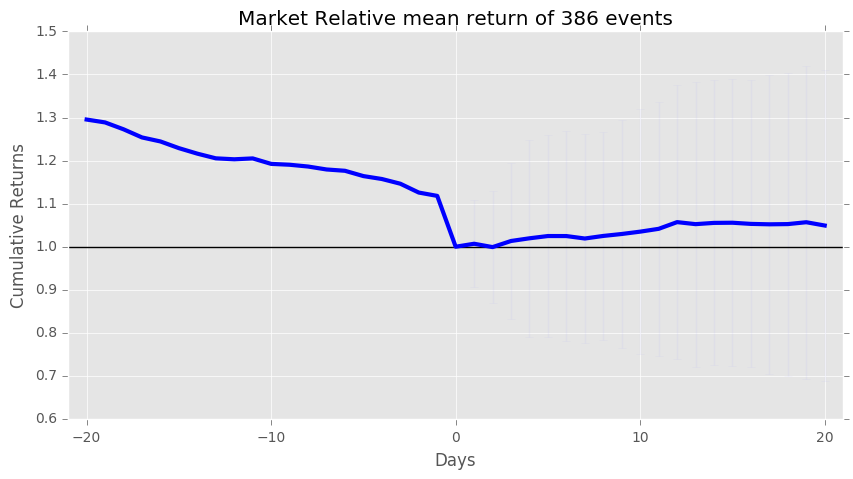

For the $6.0 event with S&P500 in 2008, we find 397 events. Date Range = 1st Jan,2008 to 31st Dec, 2009.


In [160]:
dt_start = dt.datetime(2008, 1, 1)
dt_end = dt.datetime(2009, 12, 31)
ldt_timestamps = du.getNYSEdays(dt_start, dt_end, dt.timedelta(hours=16))

c_dataobj = da.DataAccess('Yahoo')
ls_symbols2008 = c_dataobj.get_symbols_from_list('sp5002008')
ls_symbols2008.append('SPY')

ls_keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']
ldf_data2008 = c_dataobj.get_data(ldt_timestamps, ls_symbols2008, ls_keys)
d_data2008 = dict(zip(ls_keys, ldf_data2008))

for s_key in ls_keys:
    d_data2008[s_key] = d_data2008[s_key].fillna(method='ffill')
    d_data2008[s_key] = d_data2008[s_key].fillna(method='bfill')
    d_data2008[s_key] = d_data2008[s_key].fillna(1.0)

df_events2008, count2008 = find_events_on_price(ls_symbols2008, d_data2008, 6.0)
print "Creating Study 2008"
eventprofiler(df_events2008, d_data2008, i_lookback=20, i_lookforward=20,
              s_filename='MyEventStudy2008new.pdf', b_market_neutral=True, b_errorbars=True,
              s_market_sym='SPY')

print "For the $6.0 event with S&P500 in 2008, we find", count2008, "events. Date Range = 1st Jan,2008 to 31st Dec, 2009."

## Investment Evaluation
According to events we have found, now we can decide when we shall buy stocks and when we shall sell stocks.

How is the performance of our investment?

Here we use historical data again to simulate if we invest when the events happen, how much can we earn at the end of investment period.

In [143]:
def marketsim(initialMoney=1000000.0, csvFile='orders.csv', valueFile='values.csv'):
    ls_symbols = []
    ld_dates = []
    reader = csv.reader(open(csvFile, 'rU'), delimiter=',')
    for row in reader:
        # add symbol
        ls_symbols.append(row[3])
        # add order date
        ld_dates.append(dt.datetime(int(row[0]), int(row[1]), int(row[2])))

    # remove duplicates
    ls_symbols_unique = list(set(ls_symbols))
    ld_dates_unique = list(set(ld_dates))
    # sort the date
    ld_dates_unique.sort()

    # read market data
    # We need closing prices so the timestamp should be hours=16.
    dt_timeofday = dt.timedelta(hours=16)
    # Get a list of trading days between the start and the end.
    ldt_timestamps = du.getNYSEdays(ld_dates_unique[0], ld_dates_unique[-1] + dt.timedelta(days=1), dt_timeofday)
    # Creating an object of the dataaccess class with Yahoo as the source.
    c_dataobj = da.DataAccess('Yahoo')
    # Keys to be read from the data, it is good to read everything in one go.
    ls_keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']

    # Reading the data, now d_data is a dictionary with the keys above.
    # Timestamps and symbols are the ones that were specified before.
    ldf_data = c_dataobj.get_data(ldt_timestamps, ls_symbols_unique, ls_keys)
    d_data = dict(zip(ls_keys, ldf_data))

    # Filling the data for NAN
    for s_key in ls_keys:
        d_data[s_key] = d_data[s_key].fillna(method='ffill')
        d_data[s_key] = d_data[s_key].fillna(method='bfill')
        d_data[s_key] = d_data[s_key].fillna(1.0)

    # Getting the numpy ndarray of close prices.
    na_price = d_data['close'].values
    # create a trade matrix
    na_trade = np.zeros((len(ldt_timestamps), len(ls_symbols_unique)))

    # read the orders and fill in the trade shares
    reader = csv.reader(open(csvFile, 'rU'), delimiter=',')
    for row in reader:
        date_t = dt.datetime(int(row[0]), int(row[1]), int(row[2]), 16)
        symbol_t = row[3]
        operation_t = row[4]
        share_t = float(row[5])
        x_t = ldt_timestamps.index(date_t)
        y_t = ls_symbols_unique.index(symbol_t)
        if operation_t.upper() == 'BUY':
            na_trade[x_t, y_t] = na_trade[x_t, y_t] + share_t
        elif operation_t.upper() == 'SELL':
            na_trade[x_t, y_t] = na_trade[x_t, y_t] - share_t
        else:
            print 'Market operations in', csvFile, 'error!'

    # create holding matrix from trade matrix
    na_hold = np.zeros((len(ldt_timestamps), len(ls_symbols_unique)))
    for x in range(len(ldt_timestamps)):
        for y in range(len(ls_symbols_unique)):
            if x == 0:
                na_hold[x, y] = na_trade[x, y]
            else:
                na_hold[x, y] = na_trade[x, y] + na_hold[x-1, y]

    # calculate cash from the price and trade matrix
    na_cash = []
    for x in range(len(ldt_timestamps)):
        if x == 0:
            na_cash.append(initialMoney)
        else:
            na_cash.append(na_cash[x-1])

        for y in range(len(ls_symbols_unique)):
            na_cash[x] = na_cash[x] - na_price[x, y] * na_trade[x, y]

    # calculate portfolio value from price and holding matrix and cash
    na_portfolio = []
    for x in range(len(ldt_timestamps)):
        value_t = 0.0
        for y in range(len(ls_symbols_unique)):
            value_t = value_t + na_price[x, y] * na_hold[x, y]

        na_portfolio.append(value_t + na_cash[x])

    # write portfolio value to value.csv
    writer = csv.writer(open(valueFile, 'wb'), delimiter=',')
    for row in range(len(na_portfolio)):
        writer.writerow([ldt_timestamps[row].year, ldt_timestamps[row].month, ldt_timestamps[row].day, na_portfolio[row]])

Suppose our initial investment is \$1000000 and our order is recorded in a csv file.

We evaluate the value of our portfolio and store the final result into another csv file.

In [172]:
marketsim(initialMoney=1000000.0, csvFile='orders.csv', valueFile='values.csv')
my_order = pd.read_csv('orders.csv', header=None, usecols=[0,1,2,3,4,5])
print my_order.head()
my_value = pd.read_csv('values.csv', header=None, usecols=[0,1,2,3])
print my_value.head()

      0  1   2     3     4     5
0  2011  1  10  AAPL   Buy  1500
1  2011  1  13  AAPL  Sell  1500
2  2011  1  13   IBM   Buy  4000
3  2011  1  26  GOOG   Buy  1000
4  2011  2   2   XOM  Sell  4000
      0  1   2          3
0  2011  1  10  1000000.0
1  2011  1  11   998785.0
2  2011  1  12  1002940.0
3  2011  1  13  1004815.0
4  2011  1  14  1009415.0


In order to show how well our portfolio performs, we draw a time series graph of the value of our portfolio comparing with S&P 500 based on historical data and also calculate the metrics for our portfolio.

In [166]:
def analyze(valueFile='values.csv', benchmark='$SPX'):
    s_symbol = benchmark
    # read value.csv
    lf_portfolio = []
    ld_dates = []
    reader = csv.reader(open(valueFile, 'rU'), delimiter=',')
    for row in reader:
        # add symbol
        lf_portfolio.append(float(row[3]))
        # add order date
        ld_dates.append(dt.datetime(int(row[0]), int(row[1]), int(row[2])))

    # create np portfolio
    na_portfolio = np.zeros((len(ld_dates), 1))
    for x in range(len(ld_dates)):
        na_portfolio[x, 0] = lf_portfolio[x]

    # read market data
    # We need closing prices so the timestamp should be hours=16.
    dt_timeofday = dt.timedelta(hours=16)
    # Get a list of trading days between the start and the end.
    ldt_timestamps = du.getNYSEdays(ld_dates[0], ld_dates[-1] + dt.timedelta(days=1), dt_timeofday)
    # Creating an object of the dataaccess class with Yahoo as the source.
    c_dataobj = da.DataAccess('Yahoo')
    # Keys to be read from the data, it is good to read everything in one go.
    ls_keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']
    ls_symbols = [s_symbol]
    # Reading the data, now d_data is a dictionary with the keys above.
    # Timestamps and symbols are the ones that were specified before.
    ldf_data = c_dataobj.get_data(ldt_timestamps, ls_symbols, ls_keys)
    d_data = dict(zip(ls_keys, ldf_data))

    # Filling the data for NAN
    for s_key in ls_keys:
        d_data[s_key] = d_data[s_key].fillna(method='ffill')
        d_data[s_key] = d_data[s_key].fillna(method='bfill')
        d_data[s_key] = d_data[s_key].fillna(1.0)

    # Getting the numpy ndarray of close prices.
    na_price = d_data['close'].values

    lf_portfolio_ret = np.zeros(len(ldt_timestamps))
    lf_benchmark_ret = np.zeros(len(ldt_timestamps))
    for y in range(len(lf_portfolio_ret)):
        if(y == 0):
            lf_portfolio_ret[y] = 0.0
            lf_benchmark_ret[y] = 0.0
        else:
            lf_portfolio_ret[y] = na_portfolio[y, 0] / na_portfolio[y - 1, 0] - 1
            lf_benchmark_ret[y] = na_price[y, 0] / na_price[y - 1, 0] - 1

    vol_p = np.std(lf_portfolio_ret)
    daily_ret_p = np.average(lf_portfolio_ret)
    sharpe_p = daily_ret_p / vol_p * math.sqrt(252)
    cum_ret_p = na_portfolio[-1, 0] / na_portfolio[0, 0]

    vol_b = np.std(lf_benchmark_ret)
    daily_ret_b = np.average(lf_benchmark_ret)
    sharpe_b = daily_ret_b / vol_b * math.sqrt(252)
    cum_ret_b = na_price[-1, 0] / na_price[0, 0]

    print 'Details of the Performance of the portfolio :'
    print 'Data Range :', ldt_timestamps[0], 'to', ldt_timestamps[-1]
    print 'Sharpe Ratio of Fund :', sharpe_p
    print 'Sharpe Ratio of $SPX :', sharpe_b
    print 'Total Return of Fund :', cum_ret_p
    print 'Total Return of $SPX :', cum_ret_b
    print 'Standard Deviation of Fund :', vol_p
    print 'Standard Deviation of $SPX :', vol_b
    print 'Average Daily Return of Fund :', daily_ret_p
    print 'Average Daily Return of $SPX :', daily_ret_b

    ls_plot_symbols = [s_symbol, 'Portfolio']
    na_plot_value = np.zeros((len(ldt_timestamps), 2))
    for x in range(len(ldt_timestamps)):
        na_plot_value[x, 0] = lf_portfolio[0] * na_price[x, 0] / na_price[0, 0]
        na_plot_value[x, 1] = na_portfolio[x, 0]

    plt.clf()
    plt.plot(ldt_timestamps, na_plot_value)
    plt.legend(ls_plot_symbols, loc='upper left')
    plt.ylabel('Fund Value')
    plt.xlabel('Date')
    plt.show()
    #plt.savefig('marketsimBollingerAnalyze.pdf', format='pdf')

Details of the Performance of the portfolio :
Data Range : 2011-01-10 16:00:00 to 2011-12-20 16:00:00
Sharpe Ratio of Fund : 1.21540462111
Sharpe Ratio of $SPX : 0.0183391412227
Total Return of Fund : 1.13386
Total Return of $SPX : 0.97759401457
Standard Deviation of Fund : 0.00717514512699
Standard Deviation of $SPX : 0.0149090969828
Average Daily Return of Fund : 0.000549352749569
Average Daily Return of $SPX : 1.72238432443e-05


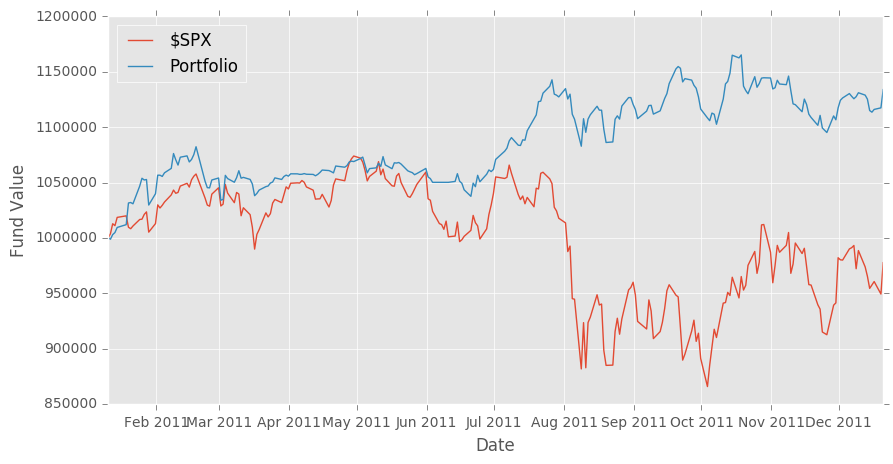

In [167]:
analyze('values.csv', '$SPX')

## Place Order
Usually we place our orders through client application.

In order to connect the gap between finding events to buy and sell stock, and evaluate our portfolio, we use a small program to automtically generate our orders based on our finding of events.

In [173]:
def find_events_to_order(ls_symbols, d_data, orderFile):
    ''' Finding the event dataframe '''
    df_close = d_data['actual_close']

    print "Finding Events"

    # Creating an empty dataframe
    df_events = copy.deepcopy(df_close)
    df_events = df_events * np.NAN

    # Time stamps for the event range
    ldt_timestamps = df_close.index
    count = 0

    # order.csv
    writer = csv.writer(open(orderFile, 'wb'), delimiter=',')

    for s_sym in ls_symbols:
        for i in range(1, len(ldt_timestamps) - 5):
            # Calculating the returns for this timestamp
            f_symprice_today = df_close[s_sym].ix[ldt_timestamps[i]]
            f_symprice_yest = df_close[s_sym].ix[ldt_timestamps[i - 1]]

            # Event is found if price[t-1] >= 5.0 && price[t] < 5.0
            if f_symprice_today < 10.0 and f_symprice_yest >= 10.0:
                df_events[s_sym].ix[ldt_timestamps[i]] = 1
                count = count + 1

                # output order.csv
                time_buy = ldt_timestamps[i]
                time_sell = ldt_timestamps[-1]
                if (i + 5) < len(ldt_timestamps):
                    time_sell = ldt_timestamps[i + 5]

                writer.writerow([time_buy.year, time_buy.month, time_buy.day, s_sym, 'BUY', 100])
                writer.writerow([time_sell.year, time_sell.month, time_sell.day, s_sym, 'SELL', 100])

    return df_events, count

In [174]:
# order.csv
orderFile = 'event_to_order.csv'

dt_start = dt.datetime(2008, 1, 1)
dt_end = dt.datetime(2009, 12, 31)
ldt_timestamps = du.getNYSEdays(dt_start, dt_end, dt.timedelta(hours=16))

c_dataobj = da.DataAccess('Yahoo')
ls_symbols2012 = c_dataobj.get_symbols_from_list('sp5002012')

ls_keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']
ldf_data2012 = c_dataobj.get_data(ldt_timestamps, ls_symbols2012, ls_keys)
d_data2012 = dict(zip(ls_keys, ldf_data2012))

for s_key in ls_keys:
    d_data2012[s_key] = d_data2012[s_key].fillna(method='ffill')
    d_data2012[s_key] = d_data2012[s_key].fillna(method='bfill')
    d_data2012[s_key] = d_data2012[s_key].fillna(1.0)

df_events, count = find_events_to_order(ls_symbols2012, d_data2012, orderFile)

Finding Events


## Example: Bollinger Bands
Bollinger Bands is a tool invented by John Bollinger in the 1980s as well as a term trademarked by him in 2011.[3]

We use a traditional Bollinger Bands.

1. use 20-day moving average mean
2. use moving average plus 2 times of a 20-day standard deviation as upper bound
3. use moving average minus 2 times of a 20-day standard deviation as lower bound

It is a good indicator to buy or long the stock when the 20-day moving average mean is higher than the upper bound on one day.

And it is also a good indicator to sell or short the stock when the 20-day moving average mean is lower than the upper bound on one day.

Because it tends to revert to the mean average price when the price is out of Bollinger Bands.

In [149]:
def bollinger_bands_event():
    dt_start = dt.datetime(2010, 1, 1)
    dt_end = dt.datetime(2010, 12, 31)
    # ls_symbols = ['AAPL', 'GOOG', 'IBM', 'MSFT']
    ls_symbols = ['AAPL']
    # We need closing prices so the timestamp should be hours=16.
    dt_timeofday = dt.timedelta(hours=16)
    # Get a list of trading days between the start and the end.
    ldt_timestamps = du.getNYSEdays(dt_start, dt_end, dt_timeofday)
    # Creating an object of the dataaccess class with Yahoo as the source.
    c_dataobj = da.DataAccess('Yahoo')
    # Keys to be read from the data, it is good to read everything in one go.
    ls_keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']

    # Reading the data, now d_data is a dictionary with the keys above.
    # Timestamps and symbols are the ones that were specified before.
    ldf_data = c_dataobj.get_data(ldt_timestamps, ls_symbols, ls_keys)
    d_data = dict(zip(ls_keys, ldf_data))

    # Filling the data for NAN
    for s_key in ls_keys:
        d_data[s_key] = d_data[s_key].fillna(method='ffill')
        d_data[s_key] = d_data[s_key].fillna(method='bfill')
        d_data[s_key] = d_data[s_key].fillna(1.0)

    # Getting the numpy ndarray of close prices.
    na_price = d_data['close'].values

    na_bollingerbands = (na_price - pd.rolling_mean(na_price, 20)) / pd.rolling_std(na_price, 20)

#     print 'ls_symbols', ls_symbols
#     for x in range(len(ldt_timestamps)):
#         print ldt_timestamps[x], na_bollingerbands[x]

    na_mean = pd.rolling_mean(na_price, 20)
    na_upperbands = na_mean + pd.rolling_std(na_price, 20)
    na_lowerbands = na_mean - pd.rolling_std(na_price, 20)

    plt.clf()
    plt.plot(ldt_timestamps, na_price)
    plt.plot(ldt_timestamps, pd.rolling_mean(na_price, 20))
    plt.plot(ldt_timestamps, na_upperbands)
    plt.plot(ldt_timestamps, na_lowerbands)
    x = np.array(ldt_timestamps)
    y1 = np.array(na_upperbands).reshape(len(ldt_timestamps))
    y2 = np.array(na_lowerbands).reshape(len(ldt_timestamps))

    # plt.fill_between(ldt_timestamps, na_upperbands, na_lowerbands, facecolor='gray', alpha=0.2)
    plt.fill_between(x, y1, y2, facecolor='gray', alpha=0.2)
    plt.legend([ls_symbols, 'Avg', 'upper band', 'lower band'], loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close')
    plt.show()
#     plt.savefig('bollingerbands1.pdf', format='pdf')

#     plt.clf()
#     plt.plot(ldt_timestamps, na_bollingerbands)
#     plt.plot(ldt_timestamps, (na_upperbands - na_mean) / pd.rolling_std(na_price, 20))
#     plt.plot(ldt_timestamps, (na_lowerbands - na_mean) / pd.rolling_std(na_price, 20))
#     plt.axhline(y=1, color='gray')
#     plt.axhline(y=-1, color='gray')
#     plt.xlabel('Date')
#     plt.ylabel('Bollinger Feature')
#     plt.savefig('bollingerbands2.pdf', format='pdf')

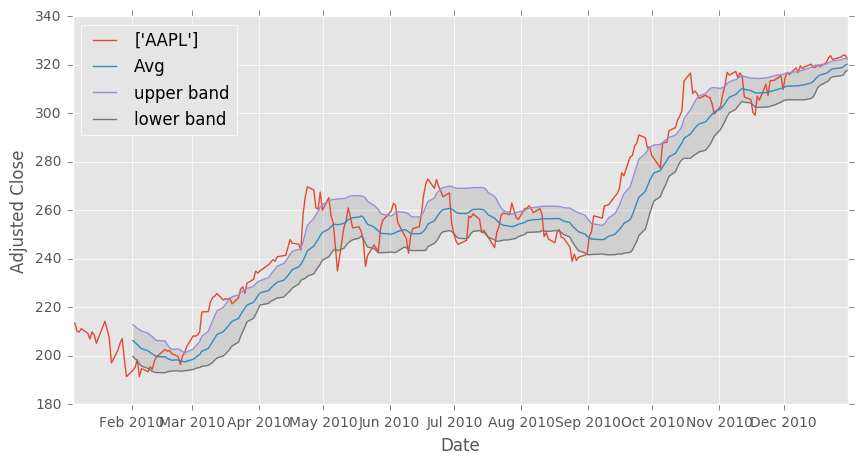

In [150]:
bollinger_bands_event()

In [151]:
def find_bollinger_events(ls_symbols, d_data):
    ''' Finding the event dataframe '''
    df_close = d_data['close']

    print "Finding Events"

    # Creating an empty dataframe
    df_events = copy.deepcopy(df_close)
    df_events = df_events * np.NAN

    df_bollinger = copy.deepcopy(df_events)
    df_bollinger = (df_close - pd.rolling_mean(df_close, 20)) / pd.rolling_std(df_close, 20)

    # Time stamps for the event range
    ldt_timestamps = df_close.index
    count = 0

    for s_sym in ls_symbols:
        for i in range(1, len(ldt_timestamps)):
            # Calculating the bollinger value for this timestamp
            f_symbollinger_today = df_bollinger[s_sym].ix[ldt_timestamps[i]]
            f_symbollinger_yest = df_bollinger[s_sym].ix[ldt_timestamps[i-1]]
            f_spxbollinger_today = df_bollinger['SPY'].ix[ldt_timestamps[i]]

            # Event is found if Bollinger value for the equity today <= -2.0
            #                   Bollinger value for the equity yesterday >= -2.0
            #                   Bollinger value for SPY today >= 1.0
            if f_symbollinger_today <= -2.0 and f_symbollinger_yest >= -2.0 and f_spxbollinger_today >= 1.0:
                df_events[s_sym].ix[ldt_timestamps[i]] = 1
                count = count + 1

    return df_events, count

In [165]:
dt_start = dt.datetime(2008, 1, 1)
dt_end = dt.datetime(2009, 12, 31)
ldt_timestamps = du.getNYSEdays(dt_start, dt_end, dt.timedelta(hours=16))

c_dataobj = da.DataAccess('Yahoo')
ls_symbols = c_dataobj.get_symbols_from_list('sp5002012')
ls_symbols.append('SPY')

ls_keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']
ldf_data = c_dataobj.get_data(ldt_timestamps, ls_symbols, ls_keys)
d_data = dict(zip(ls_keys, ldf_data))

for s_key in ls_keys:
    d_data[s_key] = d_data[s_key].fillna(method='ffill')
    d_data[s_key] = d_data[s_key].fillna(method='bfill')
    d_data[s_key] = d_data[s_key].fillna(1.0)

df_events, count = find_bollinger_events(ls_symbols, d_data)
print "The total count is", count

print "Creating Bollinger Band Indicator Study 2012"
# ep.eventprofiler(df_events, d_data, i_lookback=20, i_lookforward=20,
#                  s_filename='MyBollingerEventStudy.pdf', b_market_neutral=True, b_errorbars=True,
#                  s_market_sym='SPY')

Finding Events
The total count is 295
Creating Bollinger Band Indicator Study 2012


In [153]:
def find_bollinger_events_to_order(ls_symbols, d_data, orderFile):
    ''' Finding the event dataframe '''
    df_close = d_data['close']

    print "Finding Events"

    # Creating an empty dataframe
    df_events = copy.deepcopy(df_close)
    df_events = df_events * np.NAN

    df_bollinger = copy.deepcopy(df_events)
    df_bollinger = (df_close - pd.rolling_mean(df_close, 20)) / pd.rolling_std(df_close, 20)

    # Time stamps for the event range
    ldt_timestamps = df_close.index
    count = 0

    # order.csv
    writer = csv.writer(open(orderFile, 'wb'), delimiter=',')

    for s_sym in ls_symbols:
        for i in range(1, len(ldt_timestamps)):
            # Calculating the bollinger value for this timestamp
            f_symbollinger_today = df_bollinger[s_sym].ix[ldt_timestamps[i]]
            f_symbollinger_yest = df_bollinger[s_sym].ix[ldt_timestamps[i-1]]
            f_spxbollinger_today = df_bollinger['SPY'].ix[ldt_timestamps[i]]

            # Event is found if Bollinger value for the equity today <= -2.0
            #                   Bollinger value for the equity yesterday >= -2.0
            #                   Bollinger value for SPY today >= 1.0
            if f_symbollinger_today < -2.0 and f_symbollinger_yest >= -2.0 and f_spxbollinger_today >= 1.4:
                df_events[s_sym].ix[ldt_timestamps[i]] = 1
                count = count + 1

                # output order.csv
                time_buy = ldt_timestamps[i]
                time_sell = ldt_timestamps[-1]
                if (i + 5) < len(ldt_timestamps):
                    time_sell = ldt_timestamps[i + 5]

                writer.writerow([time_buy.year, time_buy.month, time_buy.day, s_sym, 'BUY', 100])
                writer.writerow([time_sell.year, time_sell.month, time_sell.day, s_sym, 'SELL', 100])

    return df_events, count

In [154]:
# order.csv
orderFile = 'bollinger_order.csv'

dt_start = dt.datetime(2008, 1, 1)
dt_end = dt.datetime(2009, 12, 31)
ldt_timestamps = du.getNYSEdays(dt_start, dt_end, dt.timedelta(hours=16))

c_dataobj = da.DataAccess('Yahoo')
ls_symbols = c_dataobj.get_symbols_from_list('sp5002012')
ls_symbols.append('SPY')

ls_keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']
ldf_data = c_dataobj.get_data(ldt_timestamps, ls_symbols, ls_keys)
d_data = dict(zip(ls_keys, ldf_data))

for s_key in ls_keys:
    d_data[s_key] = d_data[s_key].fillna(method='ffill')
    d_data[s_key] = d_data[s_key].fillna(method='bfill')
    d_data[s_key] = d_data[s_key].fillna(1.0)

df_events, count = find_events_to_order(ls_symbols, d_data, orderFile)

Finding Events


In [175]:
marketsim(initialMoney=1000000.0, csvFile='bollinger_order.csv', valueFile='bollinger_value.csv')
bollinger_order = pd.read_csv('bollinger_order.csv', header=None, usecols=[0,1,2,3,4,5])
print bollinger_order.head()
bollinger_value = pd.read_csv('bollinger_value.csv', header=None, usecols=[0,1,2,3])
print bollinger_value.head()

      0   1   2   3     4    5
0  2008  10  23  AA   BUY  100
1  2008  10  30  AA  SELL  100
2  2008  11  17  AA   BUY  100
3  2008  11  24  AA  SELL  100
4  2008  12   1  AA   BUY  100
      0  1  2          3
0  2008  1  3  1000000.0
1  2008  1  4   999892.0
2  2008  1  7   999881.0
3  2008  1  8   999800.0
4  2008  1  9   999814.0


Even under internatinal finance crisis in 2008, we still obtain little earning, comparing with the performance of S&P 500, if we trade according to Bollinger Bands index.

Details of the Performance of the portfolio :
Data Range : 2008-01-03 16:00:00 to 2009-12-22 16:00:00
Sharpe Ratio of Fund : 0.581601213786
Sharpe Ratio of $SPX : -0.197350690895
Total Return of Fund : 1.009801
Total Return of $SPX : 0.772561430664
Standard Deviation of Fund : 0.000538523266095
Standard Deviation of $SPX : 0.0220690337897
Average Daily Return of Fund : 1.97301099253e-05
Average Daily Return of $SPX : -0.000274360572461


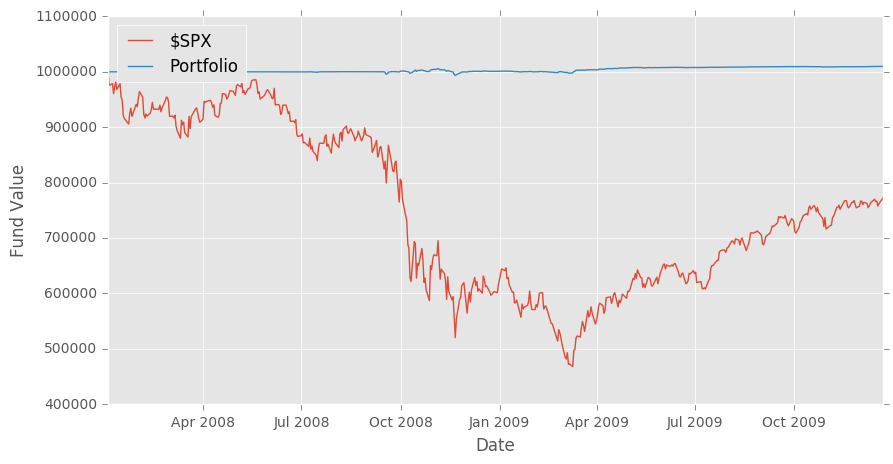

In [176]:
analyze('bollinger_value.csv', '$SPX')

# Prediction of price change


The overall architecture for the stock trading is as follows:
    

<img src="4.png">
source:  https://www.google.com/search?q=machine+learning+model&biw=1280&bih=703&source=lnms&tbm=isch&sa=X&ved=0ahUKEwiyuPun4u3QAhUJ9GMKHesnC3kQ_AUIBigB#imgrc=z01IGL4yhym_TM%3A 

We want to train a the model for predicting stock price change. For the stock model, we care about future price and future return, We would like to know the price change. If it is positive, we are highly likely to buy the stocks. If the price change is negative, we may not buy it.

so we will make the price change as the prediction Y. The important features which influence the Y we care about can be price momentum, Bollinger value, and current price. So we would like to make these three as the input X.

* Select X1,X2,X3 as predictive features
* Select Y as price change
* Determine the time T1 for X1,X2,X3, T2 for Y, T2 > T1, so we can make prediction
* Train X and Y
* Predict


Then based on the prediction for price change, we can try to make buy and sell decisions to earn profit.

Finally, we will introduce reinforcement learning to try to make the computer learn the strategy and make the decision.


## Algorithms for Model 

For train X and Y, we first need to use the choose the regression algorithms for them.

There are three algorithms we will implement and evaluate.  
* KNN learner
* Linear Regression learner
* Bootstrap Aggregating learner.

The goal of these algorithms are to implement regression and get the numerical result. By comparing these three algorithms, we can figure out which one has the best result accuracy and then choose that algorithm to do the prediction on stock market for the stock price change.

The model theory is to use current X as price momentum, Bollinger value, and current price at time T1 to predict the price Y in time T2. T2 is after T1, so we can use current data to predict the future price. 


We use root mean squared error for the evaluation of accuracy. It is as follows:
    <img src = '5.png'>
    
We can use to estimate the accuracy of our regression algorithm.

We use correlation to estimate the relashionship between the predicted value and real y value.
    <img src = '6.png'>
"In statistics, dependence or association is any statistical relationship, whether causal or not, between two random variables or two sets of data"(wikipidea). The range of y_actual and y_predict is [-1,1]. The more the correlation is close to 1, the more strong relationship the two variables have.


## Linear regression

First, let us consider linear regression. 
Suppose you have a traning dataset X as m*n array, the true Y value as n*1 array. You would like to find the linear regression for X and Y.
Y = W * X + B

As we have learned in 15688, we can first initilate W0, B0 and then get the predicted value of Y0. Then compare the square difference between Y0 and Y. Then using gradient to update W0 to reduce the loss function. Through iteration, We can get a W and B which predicts most accuary.


Structure for the Linear Regression learner class is as follows:
​
* learner = LinRegLearner() // to establish the linear regression learner
* learner.addEvidence(Xtrain, Ytrain)  //to add trainging dataset into the learner
* Y = learner.query(Xtest) // query is to get the value
​
​
The code for linear regresssion is as follows:


In [ ]:
import numpy as np

class LinRegLearner(object):

    def __init__(self, verbose = False):
        pass # move along, these aren't the drones you're looking for

    def add_evidence(self,dataX,dataY):
        """
        @summary: Add training data to learner
        @param dataX: X values of data to add
        @param dataY: the Y training values
        """
        # slap on 1s column so linear regression finds a constant term
        newdataX = np.ones([dataX.shape[0],dataX.shape[1]+1])
        newdataX[:,0:dataX.shape[1]]=dataX
        # build and save the model
        self.model_coefs, residuals, rank, s = np.linalg.lstsq(newdataX, dataY)
        
    def query(self,points):
        """
        @summary: Estimate a set of test points given the model we built.
        @param points: should be a numpy array with each row corresponding to a specific query.
        @returns the estimated values according to the saved model.
        """
        return (self.model_coefs[:-1] * points).sum(axis = 1) + self.model_coefs[-1]
    
    citing source:https://github.com/snknikolov/ml4t-quantsoftware/tree/master/mc3_p1

In [ ]:
For the test, we sepetate the data ripple.csv to two parts. The 60% percent part is as training data. The 40% percent part is as testing data. 

The result is as follows:

In train dataset:
* ('RMSE: ', 0.7053750811060775)
* ('corr: ', 0.040607011093010785)

In test dataset:
* ('RMSE: ', 0.7040934168495881)
* ('corr: ', 0.016266345717524888)


## KNN for regression

In class 15688, we have learned K nearest neighbor(KNN) for classification. Here we will use KNN for regression which predicts the numerical value. 

The difference between linear regression and KNN in regression is that linear regression uses data to learn the paraeter W to reduce the least squred error. KNN is based on the data to select the mean of k nearest neighbors. This is 100% nonparametric.

Structure for KNN is as follows:
* learner = KNNLearner(k = 3) # establish KNN learner
* learner.addEvidence(Xtrain, Ytrain) # giving training dataset to it
* Y = learner.query(Xtest) # query the predicted y
​
Where "k" is the number of nearest neighbors to find. Xtrain and Xtest can be multiple dimentional since there can be many features. Y and Ytrain are single dimension ndarrays that indicate the value we are attempting to predict with X.

The solution for predicting Y value based on k nearest neighbours is as follows:

* use a heapq to to keep track of the k nearest neighbours
* heap queue is using the negative euclidean distance for priority

Implemented in the following way:

I) Fill the heap with the first k vectors from data set

II) Keep a current minimum (the vector farthest from query vector).

III) For each of the remaining vectors in data set.

         1) Compute the distance between query and data vector.
         
         2) Negate the distance (larger distances have smaller value).
         
         3) If the current value is larger than current minimum:
               - Remove current min from heap and add current pair.
               - Update current min.
           

In [ ]:
import numpy as np
import math
from heapq import heappush, heapreplace, nsmallest

class KNNLearner:

    def __init__(self, k=5, verbose=False):
        """ k-nearest neighbours learner, with default value of k=3. """
        if k <= 0:
            raise ValueError('k should be > 0')
        self.k = k
        self.dataX = None
        self.dataY = None
        self.verbose = verbose

    def add_evidence(self, dataX, dataY):    
        self.dataX = dataX 
        self.dataY = dataY

    def predict_y(self, point):
        heap = []
        
        # Add first k elements to fill heapq
        for val in zip(self.dataX[:self.k], self.dataY[:self.k]):
            diff = point-val[0] # coordinates are at pos 0
            n_summed = np.sum((np.square(diff))) # sum the squares of diff
            euclid_dist = -math.sqrt(n_summed) # negate the distance
            pair = (euclid_dist, val[1]) # y values are at position 1
            heappush(heap, pair)

        # Compute the current minimum (largest distance).
        # Updated whenever the smallest element is removed.
        curr_min = nsmallest(1, heap)[0][0]
        
        # Check remaining elements
        for val in zip(self.dataX[self.k:], self.dataY[self.k:]): 
            diff = point-val[0]
            n_summed = (np.sum(np.square(diff)))
            euclid_dist = -math.sqrt(n_summed)
            
            if euclid_dist > curr_min:
                pair = (euclid_dist, val[1])
                heapreplace(heap, pair) # Remove smallest, add current
                curr_min = nsmallest(1, heap)[0][0] # Update current min elem
        
        # Get the Y-values from the heap and return the mean.
        result = [x[1] for x in heap]
        return sum(result) / float(len(result))

    def query(self, points):
        """ Query predicted data for each point/vector in points. """
        if self.dataX is None or self.dataY is None:
            raise UnboundLocalError(
            'Training data not found. Use addEvidence to add training data first.')
        pred = []
        for point in points:
            predY = self.predict_y(point)
            pred.append(predY)

        if self.verbose:
            print(pred)
            
        return np.asarray(pred)
    
    Citing source: https://github.com/snknikolov/ml4t-quantsoftware/tree/master/mc3_p1

For the test, we sepetate the data ripple.csv to two parts. The 60% percent part is as training data. The 40% percent part is as testing data. 

The result is as follows:
In sample results

* ('RMSE: ', 0.1365901873116998)

* ('corr:', 0.98136032690068831)

Out of sample results

* ('RMSE: ', 0.2077621500539229)

* ('corr: ', 0.9555374981656638)


For the same data, we can find that KNN has a better effect than linear regression. The stock price is of course not a linrea regression, so we would like to use KNN for its price change.

The RMSE shows that KNN has a pretty good accuracy for the prediction.

## Improve KNN using Bootstrap Aggregating

We have found the KNN learner can do a good prediction on the data prediction. Is there a way to improve its performance better?

One way to improve it is to use the Bootstrap Aggregating learner. It contains random bags. 

The structure for the Bootstrap Aggregating learner:

* learner = BagLearner(learner = KNNLearner, bags = 20, boost = false)
* learner.addEvidence(Xtrain, Ytrain)
* Y = learner.query(Xtest)

"bags" is the number of learners you should train using Bootstrap Aggregation. 

## Bootstrap theory 

In [ ]:

import numpy as np
import math
from random import randrange

class BagLearner:

    def __init__(self, learner, kwargs, bags, boost=False, verbose=False):
        """ Parameters
            ---------------
            learner - the type of learner used for bagging
            kwargs - arguments for learner
            bags - the number of "bags" (subsets of data) used for training
            boost - use Ada boost?
            verbose - print yielded Y values?
        """
        self.learner = learner(**kwargs)
        self.bags = bags
        self.boost = boost
        self.verbose = verbose
        self.dataX = None
        self.dataY = None

    def add_evidence(self, dataX, dataY):
        """ Add training data. """
        self.dataX = dataX
        self.dataY = dataY

        
    def query(self, points):
        """ Get estimated values by bagging
            For each "bag":
            1) Get some random indices (uniformly, w/ replacement).
            2) Set the learner's training data using these indices.
            3) Get the estimated Y values from the learner.
            
            Finally, return the mean of all learners' estimates.
        """
        
        def get_rand():    
            """ Generate random integers(with replacement), use to extract data at random.
                All integers are in range (0, total number of indices in dataX).
                Return a subset of the original data for X and Y using the random indices.
            """
            rands = []
            for i in range(len(self.dataX)):
                rands.append(randrange(len(self.dataX)))
            return self.dataX[rands], self.dataY[rands]
        
        learners = []
        for i in range(0, self.bags):
            data_x, data_y = get_rand()
            self.learner.add_evidence(data_x, data_y)
            est_Y = self.learner.query(points)
            learners.append(est_Y)
            
        # Return the mean of the outputs
        return np.mean(learners, axis=0)
    Citing source: https://github.com/snknikolov/ml4t-quantsoftware/tree/master/mc3_p1

In [ ]:
For the test, we sepetate the data ripple.csv to two parts. The 60% percent part is as training data. The 40% percent part is as testing data. 

The result is as follows:
In sample results

* ('RMSE: ', 0.1365901873116998)
* ('corr:', 0.98136032690068831)

Out of sample results

* ('RMSE: ', 0.2077621500539229)
* ('corr: ', 0.9555374981656638)


## Combining all in prediction model

Here, we are using the algorithms KNN and Bootstrap mentioned above to train a learner to predict the change in price of a stock of the next five trading days.

The training dataset is stock from Dec 31 2007 to 2009. The test dataset is stock from  Dec 31 2009 to 2011.

The prediction for future five day price change. 

For Xvalues, we first tranform them to be -1.0 to 1.0 to avoid the value of feature overwhlem in results.

X are momentum, rolling_std, bollinger_val.

The transform code is as follows:

In [ ]:
def normalise_data(df):
    """ Normalise stock prices using the first row of dataframe. """
    return df / df.ix[0, :]

def compute_rolling_mean(df):
    return df.rolling(window=TIME_FRAME).mean().dropna()

def compute_rolling_std(df):
    return df.rolling(window=TIME_FRAME).std().dropna()

def compute_bollinger(df, rm, rstd):
    """ Compute normalised bollinger value. """
    bb_feature = (df - rm) / (2 * rstd)
    return bb_feature.dropna()

def compute_momentum(df):
    """ Compute price momentum. 
        momentum[t] = (price[t] / price[t-N]) - 1
    """ 
    past_df = df.shift(TIME_FRAME)
    df = (df / past_df) - 1
    return df.dropna()

def compute_future_return(df):
    """ Future return is computed like so:
        price[t] = (price[t+N] / price[t]) - 1
    """
    gains_df = df.shift(-TIME_FRAME)
    return ((gains_df / df) - 1).dropna()

def analyse_data(symbols, dates):
    """ Read and analyse data 
    Computing:
    1) For X-values
        - Bollinger Band values
        - Momentum
        - Volatility (std)
    2) For Y-value
        - Future 5-day return
    Pack and return as nd-arrays to be used by learner.

    Note: Remove the first and last N rows of the results since rolling 
    values start after N days and future returns end N days earlier.
    """
    df = util.get_data(symbols, dates, addSPY=False, addCash=False).dropna()
    df = normalise_data(df)

    momentum = compute_momentum(df)
    rm = compute_rolling_mean(df) # used to compute bollinger value
    rstd = compute_rolling_std(df)
    # Remove first N days, since no rolling values are available.
    b_val = compute_bollinger(df[TIME_FRAME:], rm, rstd)
    fr = compute_future_return(df)[TIME_FRAME:]

    # Merge in a single df and remove last N rows - no future returns availabe. 
    result_x = pd.concat([momentum, rstd, b_val], axis=1, join='inner')[:-TIME_FRAME]
    data_x = result_x.as_matrix()
    data_y = fr.as_matrix()

    return data_x, data_y

    Citing source: https://github.com/snknikolov/ml4t-quantsoftware/tree/master/mc3_p2

For the training model, we will use Bootstrap Aggregating KNN to do the prediction. The number of bag is 12.
The k for KNN is 3.

The code is as follows:

In [ ]:
def train_learner(learner, data_x, data_y, query_x):
    """ Train a learner by feeding analysed data.
        Then, make an estimate for data from query_x and return it.
    """
    learner.add_evidence(data_x, data_y)
    estimate = learner.query(query_x)

    return estimate

def test_learner(dates_learn, dates_test, symbols):
    """ Test a learner.
        1) Train it with analysed data in range dates_learn
        2) Analyse the data in range dates_test.
        3) Return the estimated Y and the actual Y.
    """
    data_x, data_y = analyse_data(symbols, dates_learn)
    query_x, actual_y = analyse_data(symbols, dates_test)

    learner = bl.BagLearner(learner = knn.KNNLearner, kwargs={"k":3}, bags=12) 
    estimate_y = train_learner(learner, data_x, data_y, query_x)

    return estimate_y.flatten(), actual_y.flatten()

    Citing source: https://github.com/snknikolov/ml4t-quantsoftware/tree/master/mc3_p2

Thus, the main part of the predicton model is finished. By running the estimator.py, we can get the predicted result.

For stock price change prediction, our predicted change is as follows:
    

0.03578272  ,0.04031592 , 0.0429621 ,  0.04362807  , 0.04232555  ,0.03916158
  0.03432717,0.0280794 ,0.02071611  0.0125667   0.00398207 -0.00468585
 -0.01308817 -0.02091284 -0.02784811 -0.03361795 -0.03799173 -0.04077459
 -0.04182314 -0.04105726 -0.03846805 -0.0341176  -0.02816071 -0.02082503
 -0.01241914 -0.00333834  0.00599077  0.01511962  0.02357416  0.0309302
  0.03695387  0.04099892  0.04325503  0.04352306  0.0418366   0.03831976
  0.03318069  0.02668426  0.0191315   0.01087219  0.00224589 -0.00640291
 -0.01471693 -0.02238115 -0.02910605 -0.03461592 -0.0386831  -0.04112672
 -0.04181663 -0.04068438 -0.03773353 -0.03304784 -0.02679213 -0.01921752
 -0.01064096 -0.00146676  0.00785455  0.01687066  0.02514217  0.03224198
  0.03781211  0.04160784  0.04346818  0.04333855  0.04127138  0.03741028
  0.03198246  0.02524083  0.01751888  0.00916615  0.0005066  -0.00810021
 -0.01631095 -0.02381056 -0.03031364 -0.03554965 -0.03930683 -0.04140883
 -0.04173725 -0.04023674 -0.03693252 -0.03191816 -0.02537002 -0.01756647
 -0.00884036  0.00040336  0.00969827  0.0186066   0.02667236  0.0334885
  0.03872594  0.04214005  0.04360132  0.04307684  0.04063759  0.0364441
  0.0307221   0.02376634  0.01588753  0.00743632 -0.00124176 -0.00978592
 -0.01788237 -0.02520825 -0.03146911 -0.03642778 -0.03986692 -0.04161911
 -0.04158282 -0.03971676 -0.03605749 -0.03071906 -0.02389969 -0.01588407
 -0.00702709  0.00226308  0.0115326   0.02030775  0.02814616  0.03467037
  0.03955842  0.04259166  0.0436543   0.04273767  0.03993099  0.03541852
  0.02941706  0.02224595  0.01423077  0.00570815 -0.00297354 -0.01145648
 -0.01941379 -0.0265546  -0.03257706 -0.03724541 -0.04035617 -0.04175756
 -0.04135557 -0.03912455 -0.0351269  -0.02947497 -0.02238165 -0.01417204
 -0.00519315  0.00413247  0.01332907  0.02195097  0.0295606   0.03578272
  0.04031592  0.0429621   0.04362807  0.04232555  0.03916158  0.03432717
  0.0280794   0.02071611  0.0125667   0.00398207 -0.00468585 -0.01308817
 -0.02091284 -0.02784811 -0.03361795 -0.03799173 -0.04077459 -0.04182314
 -0.04105726 -0.03846805 -0.0341176  -0.02816071 -0.02082503 -0.01241914
 -0.00333834  0.00599077  0.01511962  0.02357416  0.0309302   0.03696873
  0.04099892  0.04325503  0.04352306  0.0418366   0.03831976  0.03318069
  0.02668426  0.0191315   0.01087219  0.00224589 -0.00640291 -0.01471693
 -0.02238115 -0.02910605 -0.03461592 -0.0386831  -0.04112672 -0.04181663
 -0.04068438 -0.03773353 -0.03304784 -0.02679213 -0.01921752 -0.01064096
 -0.00146676  0.00785455  0.01687066  0.02514217  0.03224198  0.03781211
  0.04160784  0.04346818  0.04333855  0.04127138  0.03741028  0.03198246
  0.02524083  0.01751888  0.00916615  0.0005066  -0.00810021 -0.01631095
 -0.02381056 -0.03031364 -0.03554965 -0.03930683 -0.04140883 -0.04173725
 -0.04023674 -0.03693252 -0.03191816 -0.02537002 -0.01756647 -0.00884036
  0.00040336  0.00969827  0.0186066   0.02667236  0.0334885   0.03872594
  0.04214005  0.04360132  0.04307684  0.04063759  0.0364441   0.0307221
  0.02376634  0.01588753  0.00743632 -0.00124176 -0.00978592 -0.01788237
 -0.02520825 -0.03146911 -0.03642778 -0.03986692 -0.04161911 -0.04158282
 -0.03971676 -0.03605749 -0.03071906 -0.02389969 -0.01588407]

Our actual change is as follows:

[ 0.03579912  0.04032639  0.04296681  0.04362713  0.04231892  0.03915001
  0.03431042  0.02805527  0.02068685  0.01253763  0.00395522 -0.00471019
 -0.01311609 -0.02093605 -0.02786684 -0.03363508 -0.03800394 -0.04078044
 -0.04182357 -0.04105293 -0.03845748 -0.03410341 -0.02813956 -0.02079896
 -0.01239476 -0.00330932  0.00602379  0.01514443  0.02359492  0.03095065
  0.03684865  0.0410107   0.04325868  0.04352066  0.04182838  0.03830738
  0.03316215  0.02665868  0.01910661  0.01084257  0.00221561 -0.00642485
 -0.01473892 -0.02240426 -0.02912309 -0.03462879 -0.03869271 -0.04113161
 -0.0418159  -0.04067838 -0.03772291 -0.03303188 -0.02677103 -0.01918997
 -0.0106168  -0.00144581  0.00788196  0.01690444  0.02516813  0.03225862
  0.03782824  0.04161793  0.04347059  0.04333554  0.04126426  0.03739943
  0.03195929  0.02521996  0.01749779  0.00913296  0.00047549 -0.00812638
 -0.01633567 -0.02383442 -0.03033057 -0.03556454 -0.03931616 -0.04141223
 -0.04173496 -0.04023069 -0.03691848 -0.03189714 -0.02534932 -0.01754099
 -0.00881472  0.00042405  0.00972786  0.0186339   0.02669409  0.03350531
  0.03873615  0.04214715  0.04360248  0.04307248  0.04062799  0.03642814
  0.0307042   0.02374177  0.01586316  0.00741162 -0.00126236 -0.0098121
 -0.01790384 -0.02522427 -0.03148732 -0.03644072 -0.03987305 -0.04162154
 -0.04158052 -0.03971026 -0.03604525 -0.03070092 -0.02387682 -0.01585499
 -0.00699195  0.00229658  0.01155777  0.0203293   0.02816974  0.03468834
  0.03957075  0.04259761  0.04365444  0.04273239  0.03992111  0.03539556
  0.02939935  0.02222677  0.01420555  0.00568138 -0.00299519 -0.01147939
 -0.019441   -0.02657163 -0.03259143 -0.03725574 -0.04036225 -0.0417589
 -0.04135252 -0.0391176  -0.03510443 -0.02944511 -0.02235605 -0.01413508
 -0.005152    0.00416804  0.01336798  0.02198721  0.02959214  0.03580546
  0.04033062  0.04296875  0.04362674  0.04231627  0.03914527  0.03430386
  0.02804722  0.02067769  0.01252776  0.00394504 -0.00472026 -0.01312566
 -0.02094475 -0.02787433 -0.03364106 -0.03800816 -0.0407827  -0.04182374
 -0.04105095 -0.03845339 -0.03409732 -0.02813171 -0.02078967 -0.01238443
 -0.00329844  0.00603469  0.01515481  0.02360426  0.03095848  0.03685458
  0.04101448  0.04326015  0.0435198   0.04182529  0.03830226  0.03315527
  0.02665038  0.01909728  0.0108326   0.00220542 -0.00643486 -0.01474835
 -0.02241274 -0.0291303  -0.03463443 -0.03869655 -0.04113346 -0.04181564
 -0.04067597 -0.0377184  -0.03302542 -0.02676287 -0.01918043 -0.01060631
 -0.00143489  0.0078928   0.01691465  0.0251772   0.03226609  0.03783377
  0.04162126  0.0434716   0.04333422  0.04126075  0.03739393  0.03195209
  0.02521142  0.01748829  0.00912291  0.00046531 -0.00813629 -0.01634493
 -0.02384267 -0.03033749 -0.03556985 -0.03931961 -0.04141367 -0.04173426
 -0.04022785 -0.03691357 -0.03189031 -0.02534084 -0.01753122 -0.0088041
  0.00043501  0.00973862  0.01864393  0.02670288  0.03351242  0.03874125
  0.04215002  0.04360301  0.04307072  0.04062405  0.03642227  0.03069671
  0.023733    0.01585353  0.00740151 -0.00127252 -0.00982191 -0.01791293
 -0.02523229 -0.03149394 -0.03644566 -0.03987611 -0.04162256 -0.04157941
 -0.039707   -0.03603995 -0.03069375 -0.02386805 -0.01584502]

The rmse for the predicting error is 2.5110764409824242e-05, so the accuracy is high. The correlation is 0.9999 which also shows the predicted value and actual value has strong relationship.

# Trading strategy based on prediction

Next, we will try to make a trading strategy based on this prediction.

We would like to buy when the prediction of change is positive and sell when the prediction of price change is negative. We set the threshold for price change as 0.01 for selling and buying. 

The code is as follwing:

In [ ]:
def trade_strategy(exp_change, df_prices):
    """ Generate trade orders based on expected price change. 
        An order consists of type (BUY/SELL) and a date.
        An order is triggered on day i and is then stopped on day i+N (N days later).
    """
    buy_threshold = 0.01
    sell_threshold = -0.01
    # Remove first N days, no expected change for those.
    df_prices = df_prices[TIME_FRAME:]
    dates = df_prices.index.map(lambda x: x.strftime('%Y-%m-%d'))

    orders = []

    for i in range(len(exp_change)):
        if exp_change[i] > buy_threshold:
            orders.append(['BUY', dates[i]])
            orders.append(['SELL', dates[i + TIME_FRAME]])
        
        elif exp_change[i] < sell_threshold:
            orders.append(['SELL', dates[i]])
            orders.append(['BUY', dates[i + TIME_FRAME]])

    return orders

def orders_to_csv(symbol, orders):
    """ Write orders to csv file. 
        Used for testing with the market simulator from mc2_p1. 

        Note: orders are not chronologically sorted. This is handled by the
        market simulator.
    """
    with open('orders/orders_{0}.csv'.format(symbol), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['Date', 'Symbol', 'Order', 'Shares'])
        for order in orders:
            writer.writerow([order[1], symbol, order[0], ALLOWED_LOT])
            
Citing source: https://github.com/snknikolov/ml4t-quantsoftware/blob/master/mc3_p2/estimator.py

The orders_to_csv function is to write the trade strategy into a csv file.

Thus, the trading strategy based on this is

In [14]:
import pandas as pd
trading_strategy = pd.read_csv("orders_AAPL.csv")
trading_strategy

,Date,Symbol,Order,Shares
0,2010-01-11,AAPL,BUY,100
1,2010-01-19,AAPL,SELL,100
2,2010-01-13,AAPL,BUY,100
3,2010-01-21,AAPL,SELL,100
4,2010-01-15,AAPL,BUY,100
5,2010-01-25,AAPL,SELL,100
6,2010-01-20,AAPL,BUY,100
7,2010-01-27,AAPL,SELL,100
8,2010-01-22,AAPL,BUY,100
9,2010-01-29,AAPL,SELL,100


We can also use the market simulation above to get the profits after using this strategy.

This strategy has the followsing result:

* Date Range: 2010-01-11 00:00:00 to 2011-01-31 00:00:00

* Sharpe Ratio of Fund: 1.1841395605
* Sharpe Ratio of SPY : 0.788105845466

* Cumulative Return of Fund: 45.079
* Cumulative Return of SPY : 0.138947176353

* Standard Deviation of Fund: 1.6147662275
* Standard Deviation of SPY : 0.0110893918044

* Average Daily Return of Fund: 0.120451518059
* Average Daily Return of SPY : 0.000550543965032

* Final Portfolio Value: 46079.0


So the daily return of fund is 0.120 which is much larger than the daily return of Spy 0.00055. The large return is due to the stock prices change frequently and has some certainty. This strategy has a good performance.


# Future work

More advanced strategies can be applied when making trading strategies. For example, reinforcement learning can be applied to make more robust and intelligent trading strategies.

The KNN bootstraping algorithm can have different performance on the number of K. Experiment on the K can be good.


## Summary and references
Although some of our investment based on the application of data science obtain relatively high return, it is not hundred percentage that our strategies will win in real world because of many factors. For example, in our model, we do not consider trading fee; our training data is historical data, which may be biased; our strategies are based on historical data, which does not mean that they can be applied into future.

1.QuantSoftware ToolKit: http://wiki.quantsoftware.org/

2.Yahoo Finance: http://finance.yahoo.com/

3.Bollinger Bands: https://en.wikipedia.org/wiki/Bollinger_Bands